# packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

import warnings
warnings.filterwarnings("ignore")


# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh
from plotting_helpers import *           # truncate_colormap

In [2]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
RAC3d = np.tile(RAC[np.newaxis,:,:],(nz,1,1))
# RAC3d.shape

In [4]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:

# read one basin or whole ASTE
whole = False
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
if whole:
    mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [6]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

m = 0
s = 2

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2014"] = np.array([3,4])     # tend will be calculated from tsteps before and after one month

# try a different month to see
# times["2014"] = np.array([9,10])     # tend will be calculated from tsteps before and after one month


# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

# load the files for TS terms and volume

In [7]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

thetadr = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadrdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
saltdr = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdrdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    # with dividing out hFacC grid
    theta[i,:,:,:] = THETADR[i,:,:,:]/mygrid['hFacC']/DRF3d
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/mygrid['hFacC']/DRF3d

    # without dividing out hFacC grid
    thetadr[i,:,:,:] = THETADR[i,:,:,:]  #/mygrid['hFacC']
    saltdr[i,:,:,:]  = SALTDR[i,:,:,:]  #/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

    # keeping the weights in the function
    dthetadrdt[i,:,:,:] = (THETADR[i,:,:,:] - THETADR[i-1,:,:,:])/dt[i-1]
    dsaltdrdt[i,:,:,:] = (SALTDR[i,:,:,:] - SALTDR[i-1,:,:,:])/dt[i-1]


THETADR = (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt
SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt

In [8]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


# load the files for the heat budgeting

In [9]:
# ocean and ice
AB_gT=0

# read in data for tendency
file_name = 'budg2d_snap_set1'
ETAN = read_field2d(tsstr,ny,nx,file_name,np.array(['ETAN']),mymsk,dirIn)                # m/s
PHIBOT = read_field2d(tsstr,ny,nx,file_name,np.array(['PHIBOT']),mymsk,dirIn)            # m^2/s^s
SIheff = read_field2d(tsstr,ny,nx,file_name,np.array(['SIheff']),mymsk,dirIn)            # m
SIhsnow = read_field2d(tsstr,ny,nx,file_name,np.array(['SIhsnow']),mymsk,dirIn)            # m

ETAN =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt          # m/s
PHIBOT = (PHIBOT[1, :, :] - PHIBOT[0, :, :]) / dt     # m^2/s^3
SIheff =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt    # m
SIhsnow = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt  # m

In [10]:

tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)    # J
budgO = {}
budgI = {}
budgOI = {}
budgO['fluxes'] = {}
budgI['fluxes'] = {}

budgO['fluxes']['tend'] = tmptend

budgO['tend'] = np.nansum(tmptend,axis=0)
budgI['tend'] = -myparms['flami'] * (SIheff*myparms['rhoi'] + SIhsnow*myparms['rhosn']) * RAC
budgOI['tend'] = budgO['tend'] + budgI['tend']

In [11]:
file_name = 'budg2d_zflux_set1'
TFLUX = read_field2d(tsstr,ny,nx,file_name,np.array(['TFLUX']),mymsk,dirIn)[1]                  # W/m^2
oceQsw = read_field2d(tsstr,ny,nx,file_name,np.array(['oceQsw']),mymsk,dirIn)[1]                # W/m^2
SItflux = read_field2d(tsstr,ny,nx,file_name,np.array(['SItflux']),mymsk,dirIn)[1]              # W/m^2
oceSPflx = read_field2d(tsstr,ny,nx,file_name,np.array(['oceSPflx']),mymsk,dirIn)[1]            # g/m^2/s
SFLUX = read_field2d(tsstr,ny,nx,file_name,np.array(['SFLUX']),mymsk,dirIn)[1]                  # g/m^2/s

In [12]:
file_name = "budg2d_zflux_set2"
oceQnet = read_field2d(tsstr,ny,nx,file_name,np.array(['oceQnet']),mymsk,dirIn)[1]              # W/m^2
WTHMASS = read_field2d(tsstr,ny,nx,file_name,np.array(['WTHMASS']),mymsk,dirIn)[1]              # degC.m/s 
SIaaflux = read_field2d(tsstr,ny,nx,file_name,np.array(['SIaaflux']),mymsk,dirIn)[1]            # W/m^2
oceSflux = read_field2d(tsstr,ny,nx,file_name,np.array(['oceSflux']),mymsk,dirIn)[1]            # g/m^2/s
WSLTMASS = read_field2d(tsstr,ny,nx,file_name,np.array(['WSLTMASS']),mymsk,dirIn)[1]            # PSU.m/s
SRELAX = np.zeros((ny,nx))

In [13]:
TRELAX = np.zeros((ny,nx))
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))

In [14]:
if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

In [15]:
geothFlux = 0

if myparms['SaltPlumeHeatFlux']:
    print(1)
else:
    SPforcT1=0*np.ones((ny,nx))
    oceEPtnd=0*np.ones((nz,ny,nx))

In [16]:
file_name = "budg3d_kpptend_set1"
KPPg_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['KPPg_TH']),mymsk,dirIn)[1]
KPPg_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['KPPg_SLT']),mymsk,dirIn)[1]
oceSPtnd = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['oceSPtnd']),mymsk,dirIn)[1]

file_name = "budg3d_zflux_set2"
ADVr_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_SLT']),mymsk,dirIn)[1]
ADVr_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_TH']),mymsk,dirIn)[1]
DFrE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrE_SLT']),mymsk,dirIn)[1]
DFrE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrE_TH']),mymsk,dirIn)[1]
DFrI_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrI_SLT']),mymsk,dirIn)[1]
DFrI_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrI_TH']),mymsk,dirIn)[1]

In [43]:
budgO['zconv']=TFLUX+geothFlux+SPforcT1             # W/m^2
budgI['zconv']=-(SItflux+TFLUX-TRELAX+SPforcT1)     # W/m^2

if myparms['useNLFS']==0:
    print(1)
    budgO['zconv']=budgO['zconv']-myparms['rcp']*WTHMASS[:,:]

budgI['zconv']=budgI['zconv']-SIabflux+SIacflux+SIeprflx
budgI['zconv']=budgI['zconv']+SIaaflux

In [44]:
nr = mygrid['RC'].shape[0]
trWtop = -(ADVr_TH+DFrE_TH+DFrI_TH+KPPg_TH)*myparms['rcp']
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)
mskC=mygrid['mskC']
swtop[np.isnan(mskC)]=0
trWtop=trWtop+swtop  # 323

if myparms['SaltPlumeHeatFlux']:
    tmp1 = mk3D_mod(SPforcT1,oceEPtnd) - np.cumsum(oceEPtnd,axis=0)*RAC3
    trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[1:,:,:]
    
trWtop[0,:,:]=budgO['zconv']*RAC
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

budgO["fluxes"]["trWtop"] = trWtop
budgO["fluxes"]["trWbot"] = trWbot

In [45]:
budgI["fluxes"]["trWtop"] = -RAC * (budgI["zconv"] + budgO["zconv"])
budgI["fluxes"]["trWbot"] = -RAC * budgO["zconv"]
budgO['fluxes']['zconv']=budgO['fluxes']['trWtop']-budgO['fluxes']['trWbot']

budgO['zconv'] = RAC*budgO['zconv']   # maybe mk3d mod?
budgI['zconv']=RAC*budgI['zconv']
budgOI['zconv']=budgO['zconv']+budgI['zconv']

In [46]:
# first have to get the vector values from U and V
file_name = "budg3d_hflux_set2"
# UVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['UVELMASS']),mymsk,dirIn)
# VVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['VVELMASS']),mymsk,dirIn)
ADVx_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_TH']),mymsk,dirIn)     # degC m^3/s
ADVy_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_TH']),mymsk,dirIn)
DFxE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_TH']),mymsk,dirIn)
DFyE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_TH']),mymsk,dirIn)
ADVx_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_SLT']),mymsk,dirIn)   # PSU m^3/s
ADVy_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_SLT']),mymsk,dirIn)
DFxE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_SLT']),mymsk,dirIn)
DFyE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_SLT']),mymsk,dirIn)

In [47]:
# first have to get the vector values from U and V
# get the vectors of u and v without mass weighting
ADVx_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVx_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)

for i in range((int(len(tsstr)))):
    # get values from reading before
    tmpUadvth = ADVx_TH[i]
    tmpVadvth = ADVy_TH[i]
    tmpUdfth = DFxE_TH[i]
    tmpVdfth = DFyE_TH[i]
    tmpUadvslt = ADVx_SLT[i]
    tmpVadvslt = ADVy_SLT[i]
    tmpUdfslt = DFxE_SLT[i]
    tmpVdfslt = DFyE_SLT[i]

    # define u and v velocities
    # define in theta
    tmpUadvth,tmpVadvth = get_aste_vector_face1_3(tmpUadvth,tmpVadvth,nfx,nfy,False)
    tmpUadvth,tmpVadvth = tmpUadvth[:,:-1,:-1],tmpVadvth[:,:-1,:-1]     # centering
    tmpUdfth,tmpVdfth = get_aste_vector_face1_3(tmpUdfth,tmpVdfth,nfx,nfy,False)
    tmpUdfth,tmpVdfth = tmpUdfth[:,:-1,:-1],tmpVdfth[:,:-1,:-1]     # centering
    # define in salt
    tmpUadvslt,tmpVadvslt = get_aste_vector_face1_3(tmpUadvslt,tmpVadvslt,nfx,nfy,False)
    tmpUadvslt,tmpVadvslt = tmpUadvslt[:,:-1,:-1],tmpVadvslt[:,:-1,:-1]     # centering
    tmpUdfslt,tmpVdfslt = get_aste_vector_face1_3(tmpUdfslt,tmpVdfslt,nfx,nfy,False)
    tmpUdfslt,tmpVdfslt = tmpUdfslt[:,:-1,:-1],tmpVdfslt[:,:-1,:-1]     # centering

    # add to larger arrays
    ADVx_THo[i] = tmpUadvth
    ADVy_THo[i] = tmpVadvth
    DFxE_THo[i] = tmpUdfth
    DFyE_THo[i] = tmpVdfth
    ADVx_SLTo[i] = tmpUadvslt
    ADVy_SLTo[i] = tmpVadvslt
    DFxE_SLTo[i] = tmpUdfslt
    DFyE_SLTo[i] = tmpVdfslt

In [48]:
ADVx_THo = aste_tracer2compact(ADVx_THo[1],nfx,nfy)[0]
ADVy_THo = aste_tracer2compact(ADVy_THo[1],nfx,nfy)[0]
DFxE_THo = aste_tracer2compact(DFxE_THo[1],nfx,nfy)[0]
DFyE_THo = aste_tracer2compact(DFyE_THo[1],nfx,nfy)[0]
ADVx_SLTo = aste_tracer2compact(ADVx_SLTo[1],nfx,nfy)[0]
ADVy_SLTo = aste_tracer2compact(ADVy_SLTo[1],nfx,nfy)[0]
DFxE_SLTo = aste_tracer2compact(DFxE_SLTo[1],nfx,nfy)[0]
DFyE_SLTo = aste_tracer2compact(DFyE_SLTo[1],nfx,nfy)[0]

In [49]:
tmpUo = myparms['rcp'] * (ADVx_THo + DFxE_THo)  # 
tmpVo = myparms['rcp'] * (ADVy_THo + DFyE_THo)  # 

budgO['fluxes']['hconv'] = calc_UV_conv_1face(tmpUo,tmpVo)

In [50]:
a = budgO['fluxes']['tend'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
b = budgO['fluxes']['hconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
c = budgO['fluxes']['zconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))

a[np.isnan(a)] = 0
b[np.isnan(b)] = 0
c[np.isnan(c)] = 0

In [51]:
# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

10650


In [52]:
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)

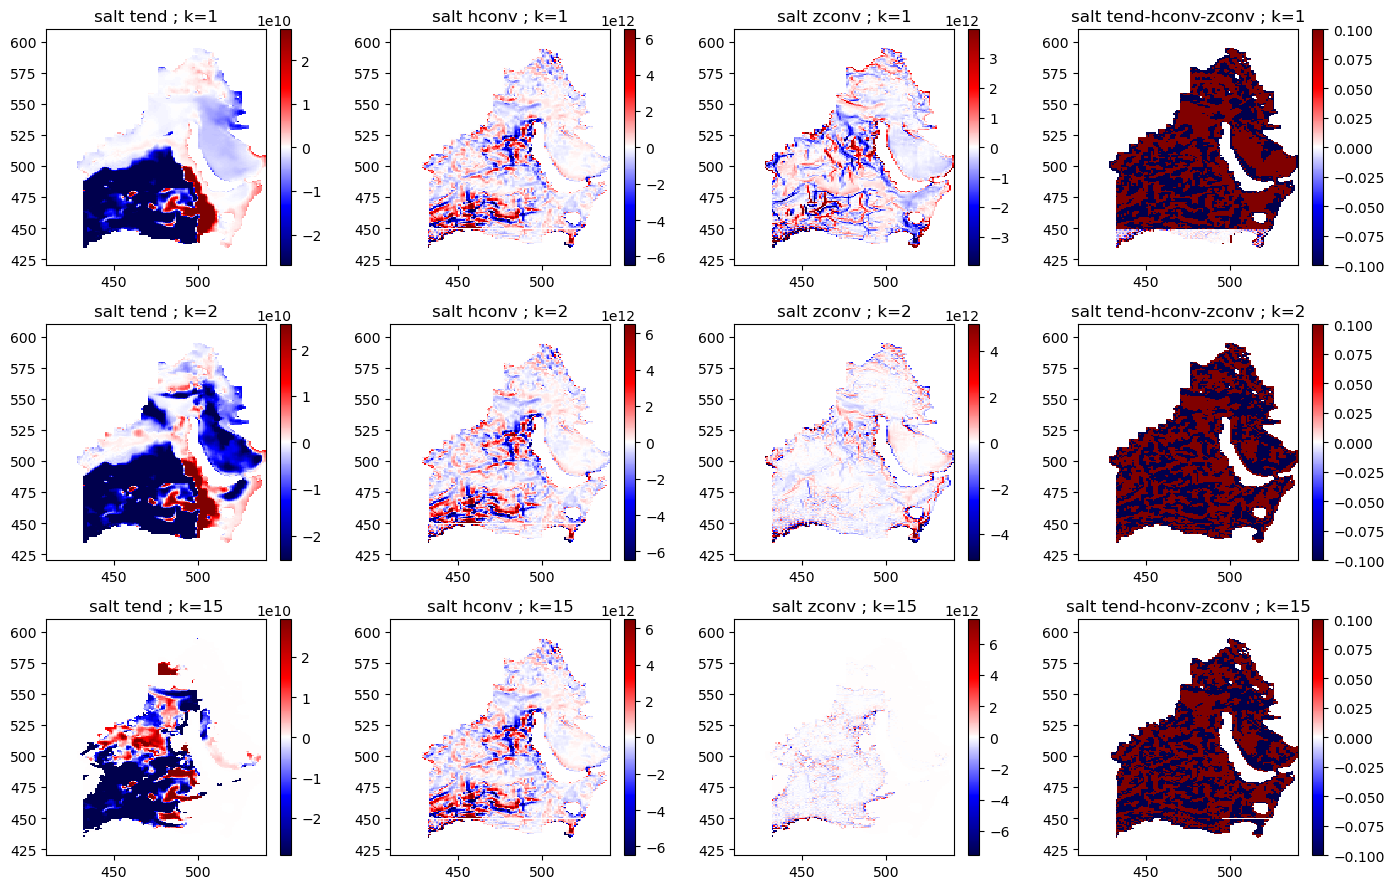

In [56]:
# Figure 2
strbudg = "salt"

klev = [1, 2, 15]
fig, axes = plt.subplots(3, 4, figsize=(14, 9))

for idx, k1 in enumerate(klev):
    str_k = f"; k={k1}"
    fourth = 1
    for j, (data, title) in enumerate([(a, 'tend'), (b, 'hconv'), (c, 'zconv'), (a-b-c, 'tend-hconv-zconv')]):
        ax = axes[idx, j]
        mydata = get_aste_tracer(data[k1-1,:, :],nfx,nfy)[0]
        #mydata = data[k1-1,:, :]
        if fourth == 4:
            pcm = ax.pcolormesh(mydata*mymsk2[0], cmap='seismic', vmin=-1e-1, vmax=1e-1)
        else:
            pcm = ax.pcolormesh(mydata*mymsk2[0], cmap='seismic', vmin=-0.99*abs(data[k1-1,:, :].max()), vmax=0.99*abs(data[k1-1,:, :].max()))
        fig.colorbar(pcm, ax=ax)

        #ax.scatter(get_aste_tracer(np.array([[533],[56]]),nfx,nfy)[0])
    
        ax.set_title(f"{strbudg} {title} {str_k}")
        ax.set_xlim(410,540)
        ax.set_ylim(420,610)

        fourth += 1

plt.tight_layout()
plt.show()

# try to run budget for salt

In [58]:
tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)
budgO = {}
budgO['fluxes'] = {}
budgI = {}
budgI['fluxes'] = {}
budgOI = {}

# ocean

budgO['fluxes']['tend'] = tmptend
budgO['tend'] = np.nansum(tmptend,axis=0)

# ice
budgI['tend'] = myparms['SIsal0'] * SIheff * myparms['rhoi'] * RAC

# ocean and ice
budgOI['tend'] = budgO['tend'] + budgI['tend']

In [61]:
if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['zconv'] = SFLUX + oceSPflx
budgI['zconv'] = -budgO['zconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['zconv'] = budgO['zconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['zconv']=-oceSflux

In [62]:
nr = mygrid['RC'].shape[0]
trWtop = -(ADVr_SLT+DFrE_SLT+DFrI_SLT+KPPg_SLT)*myparms['rhoconst']
print(trWtop.shape)
tmp1 = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)
tmp1 = tmp1 * RAC3

trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[:-1,:,:]
trWtop[0,:,:] = budgO['zconv'] * RAC    # top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['fluxes']['trWtop'] = trWtop
budgO['fluxes']['trWbot'] = trWbot

budgI['fluxes']['trWtop'] = -RAC*0
budgI['fluxes']['trWbot'] = budgO['fluxes']['trWtop'][0,:,:]  # surface because ice

budgO['fluxes']['zconv'] = budgO['fluxes']['trWtop'] - budgO['fluxes']['trWbot']
budgO['zconv'] = RAC * budgO['zconv']
budgI['zconv'] = RAC * budgI['zconv']
budgOI['zconv'] = budgO['zconv'] + budgI['zconv']

(50, 1350, 270)


In [63]:
tmpUo = myparms['rhoconst'] * (ADVx_SLTo + DFxE_SLTo)  # kg/m^3    *     PSUm^3/s = g/s
tmpVo = myparms['rhoconst'] * (ADVy_SLTo + DFyE_SLTo)  # 

budgO['fluxes']['hconv'] = calc_UV_conv_1face(tmpUo,tmpVo)

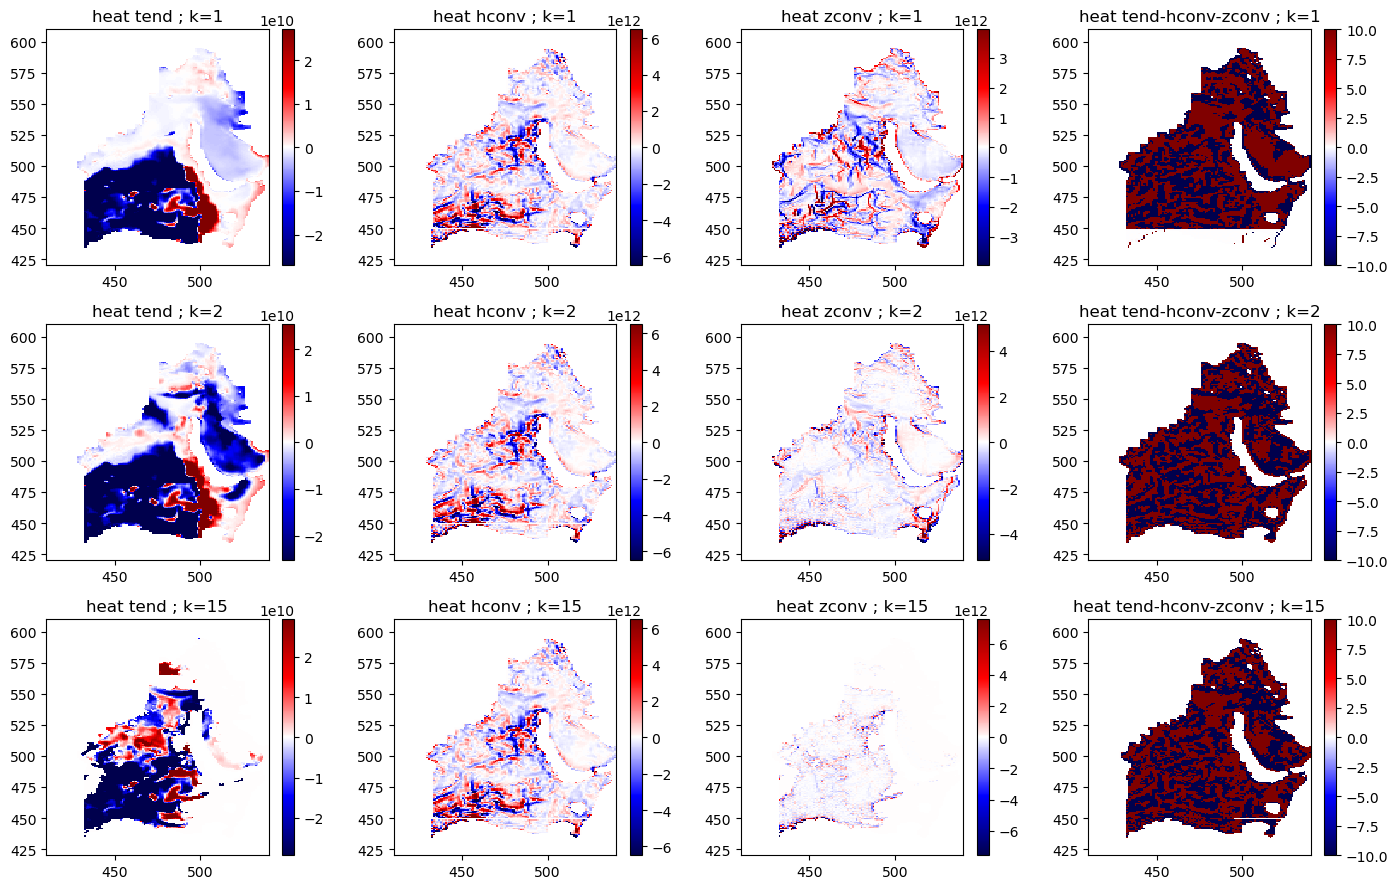

In [65]:
# Figure 2
strbudg = "heat"

klev = [1, 2, 15]
fig, axes = plt.subplots(3, 4, figsize=(14, 9))

for idx, k1 in enumerate(klev):
    str_k = f"; k={k1}"
    fourth = 1
    for j, (data, title) in enumerate([(a, 'tend'), (b, 'hconv'), (c, 'zconv'), (a-b-c, 'tend-hconv-zconv')]):
        ax = axes[idx, j]
        mydata = get_aste_tracer(data[k1-1,:, :],nfx,nfy)[0]
        #mydata = data[k1-1,:, :]
        if fourth == 4:
            pcm = ax.pcolormesh(mydata*mymsk2[0], cmap='seismic', vmin=-1e1, vmax=1e1)
        else:
            pcm = ax.pcolormesh(mydata*mymsk2[0], cmap='seismic', vmin=-0.99*abs(data[k1-1,:, :].max()), vmax=0.99*abs(data[k1-1,:, :].max()))
        fig.colorbar(pcm, ax=ax)

        #ax.scatter(get_aste_tracer(np.array([[533],[56]]),nfx,nfy)[0])
    
        ax.set_title(f"{strbudg} {title} {str_k}")
        ax.set_xlim(410,540)
        ax.set_ylim(420,610)

        fourth += 1

plt.tight_layout()
plt.show()